In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from urllib.parse import quote
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# carga do dataset
uci_url = 'https://archive.ics.uci.edu/static/public/697/'
predict_student_uci_url = 'predict+students+dropout+and+academic+success.zip'
request = urllib.request.urlopen(uci_url + urllib.parse.quote(predict_student_uci_url))
zipfile = ZipFile(BytesIO(request.read()))
filepath = TextIOWrapper(zipfile.open('data.csv'), encoding='utf-8')
dataset = pd.read_csv(filepath, sep=';')

dataset.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
# preparação dos dados

# separação em bases de treino e teste (holdout)
array = dataset.values
X = array[:,0:36]
Y = array[:,36]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=7)

# criando os folds para a validação cruzada
num_splits = 10
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=7)

KNN: 0.596498 (0.019805)
CART: 0.682966 (0.023566)
NB: 0.685778 (0.033343)
SVM: 0.494494 (0.030547)


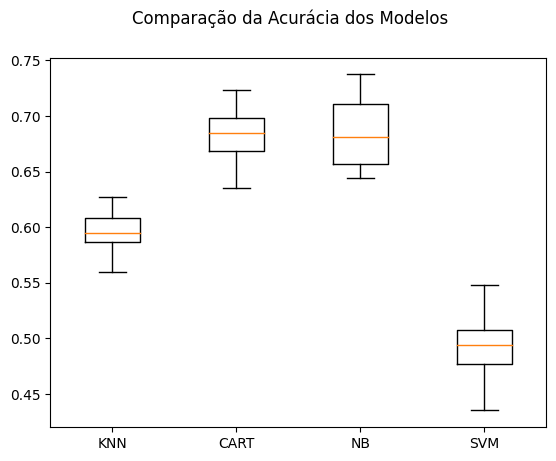

In [4]:
# modelagem

# definindo uma seed global para esta célula de código
np.random.seed(7)

# listas para aramazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# avaliando um modelo por vez
for name, model in models:
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot de comparação de modelos
fig = plt.figure()
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [5]:
# criando um modelo com tod o conjunto de treino
model = GaussianNB()
model.fit(X_train, Y_train)

# fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# estimando a acurácia no conjunto de teste
print(accuracy_score(Y_test, predictions))

0.7084745762711865
